In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("magma", )

In [12]:
palette

[(0.135053, 0.068391, 0.315),
 (0.372116, 0.092816, 0.499053),
 (0.594508, 0.175701, 0.501241),
 (0.828886, 0.262229, 0.430644),
 (0.973381, 0.46152, 0.361965),
 (0.997341, 0.733545, 0.505167)]

In [13]:
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","orange"])

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})

In [4]:
from algos import *

# Utilitary function to get the solutions

In [5]:
def get_theta_star(grads):
    fedavg_it, _, _ = fed_avg(gradients=grads,
                        theta=[0,0],
                        step=0.01, 
                        lambda_=0,
                        n_local=1,  
                        n_rounds=10000)
    
    return fedavg_it[-1]

# Quadratic Example



In [6]:
def generate_quadratic(seed):
    rng = np.random.default_rng(seed=seed)
    A = 10 * rng.random(size=(2, 2))
    A = A @ A
    A = 0.5 * (A + A.T) / 10
    A += 2 * np.eye(2)
    b = 10 * rng.random(size=2)
    c = 10 * rng.random()
    
    return A, b, c

def quadratic_function(x, y, A, b, c):
    xy = np.array([x, y])
    return 0.5 * xy.T @ A @ xy + b.T @ xy + c


def quadratic_gradient(xy, A, b):
    return A @ xy + b


# Generate two quadratic functions
A1, b1, c1 = generate_quadratic(42)
A2, b2, c2 = generate_quadratic(4)

mu = min(np.min(np.linalg.eigvals(A1)), np.min(np.linalg.eigvals(A2)))
L = max(np.max(np.linalg.eigvals(A1)), np.max(np.linalg.eigvals(A2)))

# Generate gradients
grads = [lambda x: quadratic_gradient(x, A1, b1),
         lambda x: quadratic_gradient(x, A2, b2)]

In [7]:
def run_and_plot(n_local=10, n_rounds=100, sigma=0, save=False, show_circle=False):
    
    step = 0.05
    
    theta0 = np.array([-4,0])

    theta_star = get_theta_star(grads)
    theta_star_loc = np.array([get_theta_star([grads[i]]) for i in range(2)])
    theta_star_avg = np.mean(theta_star_loc, axis=0)
    
    grad_het = np.mean([np.linalg.norm(grad(theta_star))**2 for grad in grads])
    
    mu = min(min(np.linalg.eigvals(A1)), min(np.linalg.eigvals(A2)))
    
    print(grad_het)

    
    fedavg_it, lyap_fedavg, fedavg_loc_it = fed_avg(gradients=grads,
                   theta=theta0,
                   step=step, 
                   lambda_=0,
                   n_local=n_local,  
                   n_rounds=n_rounds,
                   sigma=sigma,
                   theta_star=theta_star)

    scaffold_it, lyap_scaffold, scaffold_loc_it = scaffold(gradients=grads,
                       theta=theta0,
                       step=step, 
                       lambda_=0,
                       n_local=n_local, 
                       n_rounds=n_rounds,
                    sigma=sigma,
                                         theta_star=theta_star)
    
    # Plot level sets
    plt.figure(figsize=(8, 6))
#    plt.figure(figsize=(30, 15))

    # Create meshgrid
    x = np.linspace(-4.5, 2.5, 100)
    y = np.linspace(-3.5, 1.5, 100)
    X, Y = np.meshgrid(x, y)

    # Compute level sets
    Z1 = np.array([[quadratic_function(xi, yi, A1, b1, c1) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])
    Z2 = np.array([[quadratic_function(xi, yi, A2, b2, c2) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

    contour1 = plt.contour(X, Y, Z1+Z2, levels=40, cmap='magma')

    #plt.plot(scaffold_it[:,0], scaffold_it[:,1], marker="*", color=palette[3], rasterized=True)
    #plt.plot(scaffold_loc_it[:,0,0], scaffold_loc_it[:,0,1], marker="*", color=palette[3], alpha=0.5, rasterized=True)
    #plt.plot(scaffold_loc_it[:,1,0], scaffold_loc_it[:,1,1], marker="*", color=palette[3], alpha=0.5, rasterized=True)
    
    plt.plot(fedavg_it[:,0], fedavg_it[:,1], marker="+", color=palette[0], rasterized=True, 
             markersize=15, markeredgewidth=2, linewidth=4)
    #plt.plot(fedavg_loc_it[:,0,0], fedavg_loc_it[:,0,1], marker="*", color=palette[0], alpha=0.5, rasterized=True)
    #plt.plot(fedavg_loc_it[:,1,0], fedavg_loc_it[:,1,1], marker="*", color=palette[0], alpha=0.5, rasterized=True)
    plt.scatter([theta_star[0]], [theta_star[1]], color="red", edgecolors="black", marker="*", s=300, zorder=10)
    #plt.scatter([theta_star_loc[:,0]], [theta_star_loc[:,1]], color="purple", edgecolors="black", marker="X", s=300, zorder=10, alpha=0.5)
    plt.scatter([np.mean(fedavg_it[-10:,0])], [np.mean(fedavg_it[-10:,1])], color="purple", edgecolors="black", marker="X", s=150, zorder=10)
    
    if show_circle:
        circlesize = step/3*(n_local-1)*np.sqrt(grad_het)/mu + np.sqrt(step*n_local*sigma/mu)
        circle1 = plt.Circle(theta_star, circlesize, 
                             facecolor='purple', edgecolor='black', alpha=0.3, linewidth=2)
        circle1bis = plt.Circle(theta_star, circlesize, 
                             fill=False, edgecolor='black', linewidth=2, linestyle="dashed")
        plt.gca().add_patch(circle1)
        plt.gca().add_patch(circle1bis)
        
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()
    plt.xlim(-4.5,2.5)
    plt.ylim(-3.5,1.5)
    

    
    if save:
        os.makedirs("plots", exist_ok=True)
        plt.savefig("plots/fedavg_" + str(show_circle) + "_" + str(n_local) + "_t" + str(n_rounds) + "_s" + str(sigma) + ".pdf", bbox_inches="tight")

    plt.show()

26.12770224617555


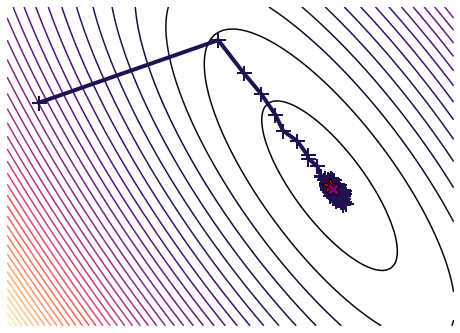

26.12770224617555


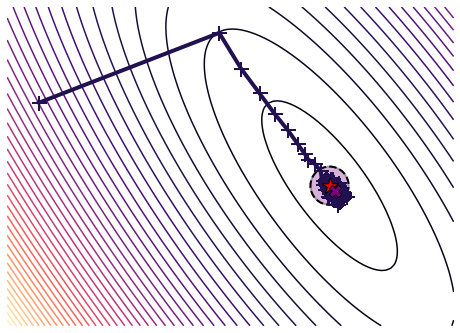

26.12770224617555


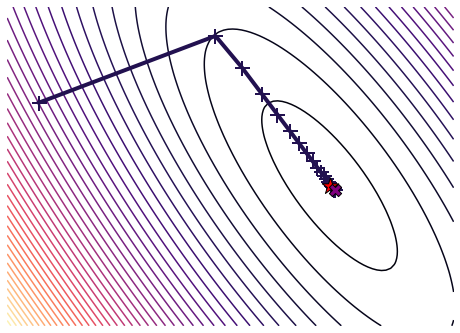

26.12770224617555


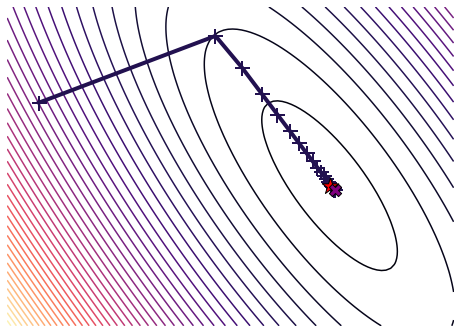

26.12770224617555


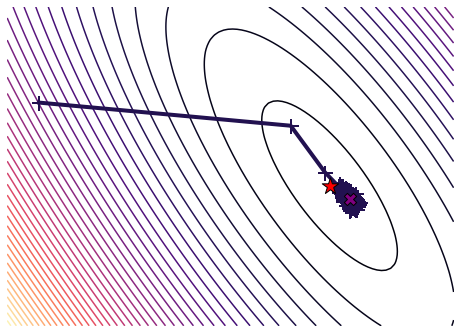

26.12770224617555


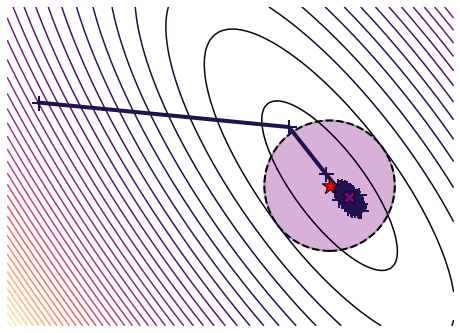

26.12770224617555


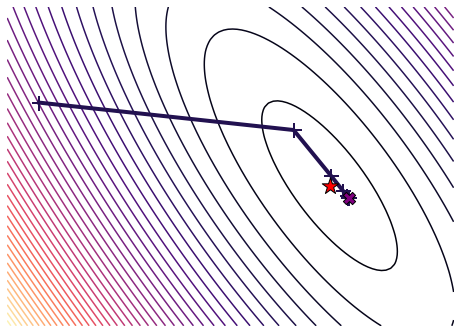

26.12770224617555


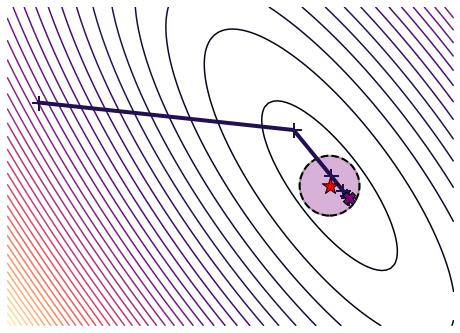

26.12770224617555


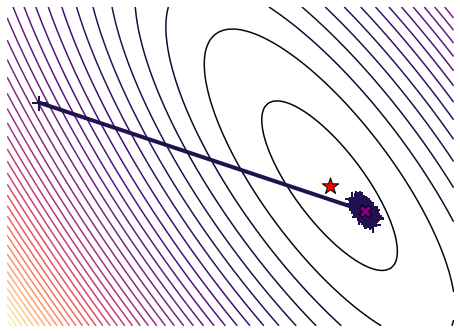

26.12770224617555


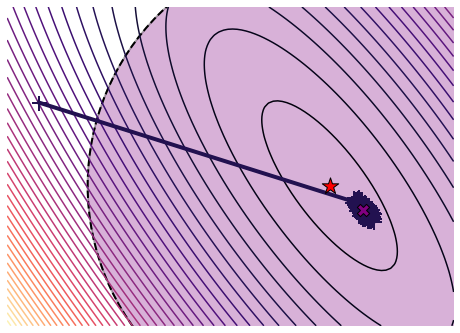

26.12770224617555


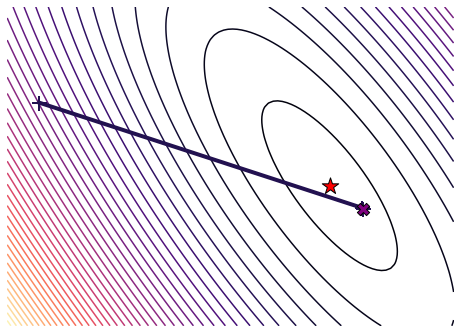

26.12770224617555


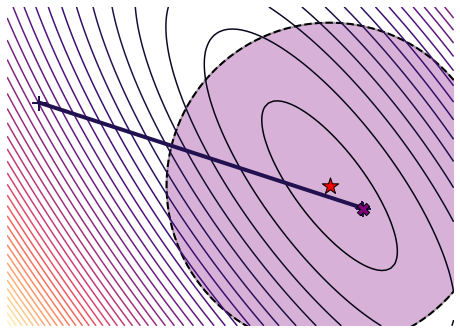

In [8]:
for n_local in [2, 10, 50]:
    run_and_plot(n_local=n_local, n_rounds=1000, sigma=1, save=True, show_circle=False)
    run_and_plot(n_local=n_local, n_rounds=1000, sigma=1, save=True, show_circle=True)
    run_and_plot(n_local=n_local, n_rounds=1000, sigma=0, save=True, show_circle=False)
    run_and_plot(n_local=n_local, n_rounds=1000, sigma=0, save=True, show_circle=True)

In [9]:
def run_and_plot_fa_scaffold(n_local=10, n_rounds=100, sigma=0, save=False, show_circle=False):
    
    step = 0.05
    theta0 = np.array([-4,0])
    

    theta_star = get_theta_star(grads)
    theta_star_loc = np.array([get_theta_star([grads[i]]) for i in range(2)])
    theta_star_avg = np.mean(theta_star_loc, axis=0)
    
    grad_het = np.mean([np.linalg.norm(grad(theta_star))**2 for grad in grads])
    
    mu = min(min(np.linalg.eigvals(A1)), min(np.linalg.eigvals(A2)))
    
    print(grad_het)

    
    fedavg_it, lyap_fedavg, fedavg_loc_it = fed_avg(gradients=grads,
                   theta=theta0,
                   step=step, 
                   lambda_=0,
                   n_local=n_local,  
                   n_rounds=n_rounds,
                   sigma=sigma,
                   theta_star=theta_star)

    scaffold_it, lyap_scaffold, scaffold_loc_it = scaffold(gradients=grads,
                       theta=theta0,
                       step=step, 
                       lambda_=0,
                       n_local=n_local, 
                       n_rounds=n_rounds,
                    sigma=sigma,
                                         theta_star=theta_star)
    
    # Plot level sets
    plt.figure(figsize=(8, 6))
#    plt.figure(figsize=(30, 15))

    # Create meshgrid
    x = np.linspace(-4.5, 2.5, 100)
    y = np.linspace(-3.5, 1.5, 100)
    X, Y = np.meshgrid(x, y)

    # Compute level sets
    Z1 = np.array([[quadratic_function(xi, yi, A1, b1, c1) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])
    Z2 = np.array([[quadratic_function(xi, yi, A2, b2, c2) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

    contour1 = plt.contour(X, Y, Z1+Z2, levels=40, cmap='magma')

    plt.plot(scaffold_it[:,0], scaffold_it[:,1], marker="*", color=palette[3], rasterized=True, 
             markersize=15, markeredgewidth=2, linewidth=4, zorder=15)
    #plt.plot(scaffold_loc_it[:,0,0], scaffold_loc_it[:,0,1], marker="*", color=palette[3], alpha=0.5, rasterized=True)
    #plt.plot(scaffold_loc_it[:,1,0], scaffold_loc_it[:,1,1], marker="*", color=palette[3], alpha=0.5, rasterized=True)
    
    plt.plot(fedavg_it[:,0], fedavg_it[:,1], marker="+", color=palette[0], rasterized=True, 
             markersize=15, markeredgewidth=2, linewidth=4)
    #plt.plot(fedavg_loc_it[:,0,0], fedavg_loc_it[:,0,1], marker="*", color=palette[0], alpha=0.5, rasterized=True)
    #plt.plot(fedavg_loc_it[:,1,0], fedavg_loc_it[:,1,1], marker="*", color=palette[0], alpha=0.5, rasterized=True)
    plt.scatter([theta_star[0]], [theta_star[1]], color="red", edgecolors="black", marker="*", s=300, zorder=20)
    #plt.scatter([theta_star_loc[:,0]], [theta_star_loc[:,1]], color="purple", edgecolors="black", marker="X", s=300, zorder=10, alpha=0.5)
    plt.scatter([np.mean(fedavg_it[-10:,0])], [np.mean(fedavg_it[-10:,1])], color="purple", edgecolors="black", marker="X", s=150, zorder=15)
 #   plt.scatter([np.mean(scaffold_it[-10:,0])], [np.mean(scaffold_it[-10:,1])], color="purple", edgecolors="black", marker="X", s=150, zorder=15)
    
    if show_circle:
        circlesize = step/3*(n_local-1)*np.sqrt(grad_het)/mu + np.sqrt(step*n_local*sigma/mu)
        circle1 = plt.Circle(theta_star, circlesize, 
                             facecolor='purple', edgecolor='black', alpha=0.3, linewidth=2)
        circle1bis = plt.Circle(theta_star, circlesize, 
                             fill=False, edgecolor='black', linewidth=2, linestyle="dashed")
        plt.gca().add_patch(circle1)
        plt.gca().add_patch(circle1bis)
        
    plt.gca().set_aspect('equal')
    plt.gca().set_axis_off()
    plt.xlim(-4.5,2.5)
    plt.ylim(-3.5,1.5)
    

    
    if save:
        os.makedirs("plots", exist_ok=True)
        plt.savefig("plots/fedavg_scaffold_" + str(show_circle) + "_" + str(n_local) + "_t" + str(n_rounds) + "_s" + str(sigma) + ".pdf", bbox_inches="tight")

    plt.show()

26.12770224617555


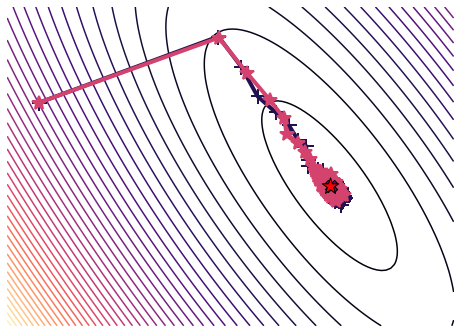

26.12770224617555


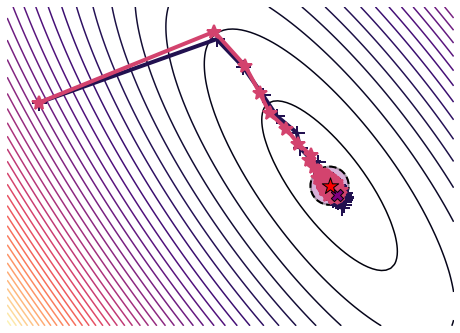

26.12770224617555


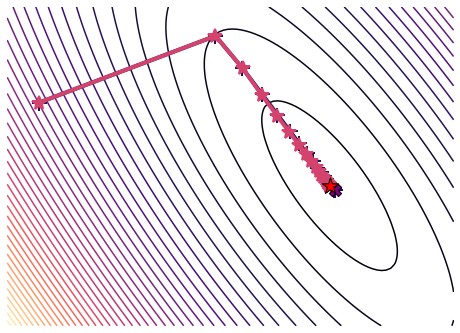

26.12770224617555


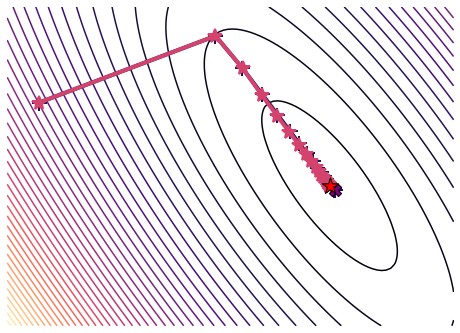

26.12770224617555


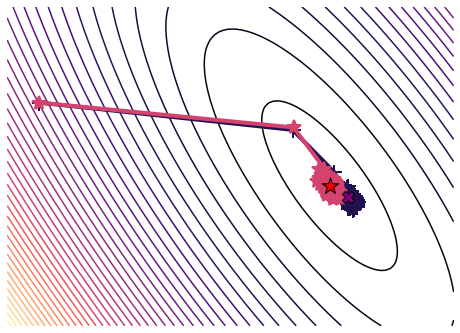

26.12770224617555


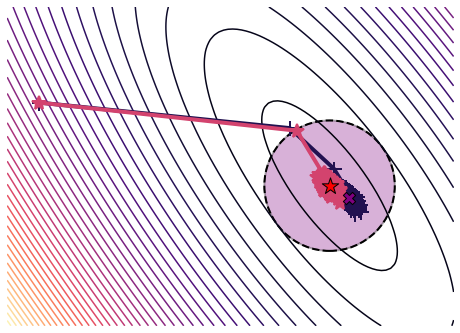

26.12770224617555


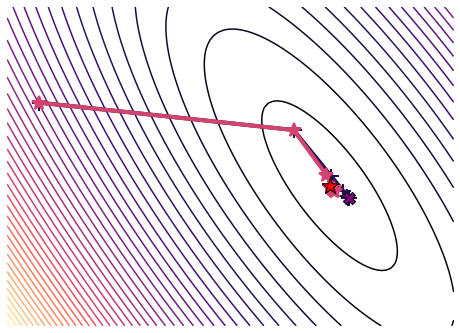

26.12770224617555


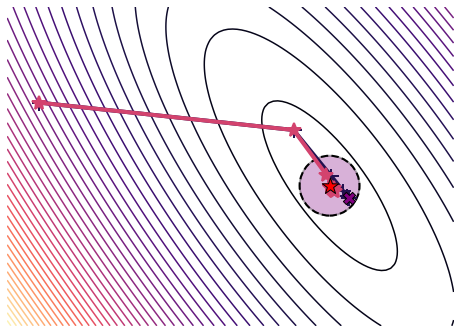

26.12770224617555


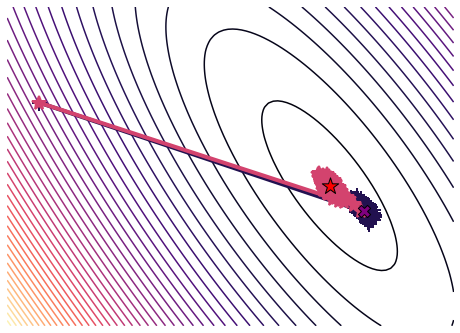

26.12770224617555


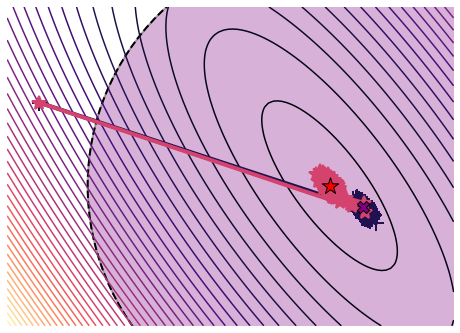

26.12770224617555


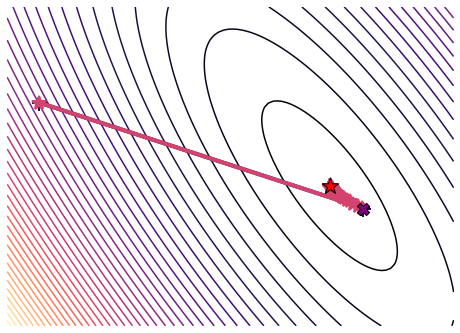

26.12770224617555


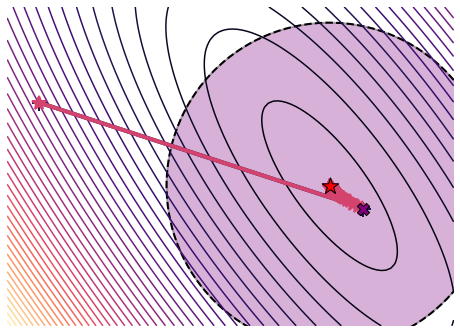

In [10]:
for n_local in [2, 10, 50]:
    run_and_plot_fa_scaffold(n_local=n_local, n_rounds=1000, sigma=1, save=True, show_circle=False)
    run_and_plot_fa_scaffold(n_local=n_local, n_rounds=1000, sigma=1, save=True, show_circle=True)
    run_and_plot_fa_scaffold(n_local=n_local, n_rounds=1000, sigma=0, save=True, show_circle=False)
    run_and_plot_fa_scaffold(n_local=n_local, n_rounds=1000, sigma=0, save=True, show_circle=True)

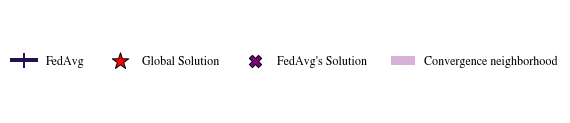

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# Define colors and markers as in the main plot
# palette = ["blue", "orange", "green", "purple"]

# Create a separate figure for the legend
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis("off")  # Hide axes

# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], marker="+", color=palette[0], markersize=15, markeredgewidth=2, linewidth=4, label="FedAvg"),
    plt.scatter([], [], color="red", edgecolors="black", marker="*", s=300, label="Global Solution"),
    plt.scatter([], [], color="purple", edgecolors="black", marker="X", s=150, label="FedAvg's Solution"),
    mpatches.Patch(facecolor='purple', alpha=0.3, label="Convergence neighborhood")
]

# Add legend to the figure in a single row
ax.legend(handles=legend_elements, loc="center", fontsize=12, frameon=False, ncol=len(legend_elements))

# Save legend figure (optional)
plt.savefig("legend_fedavg.pdf", bbox_inches="tight")

# Show the legend figure
plt.show()


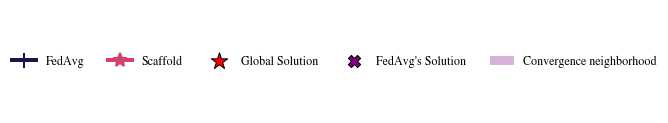

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# Define colors and markers as in the main plot
# palette = ["blue", "orange", "green", "purple"]

# Create a separate figure for the legend
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis("off")  # Hide axes

# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], marker="+", color=palette[0], markersize=15, markeredgewidth=2, linewidth=4, label="FedAvg"),
    plt.Line2D([0], [0], marker="*", color=palette[3], markersize=15, markeredgewidth=2, linewidth=4, label="Scaffold"),
    plt.scatter([], [], color="red", edgecolors="black", marker="*", s=300, label="Global Solution"),
    plt.scatter([], [], color="purple", edgecolors="black", marker="X", s=150, label="FedAvg's Solution"),
    mpatches.Patch(facecolor='purple', alpha=0.3, label="Convergence neighborhood")
]

# Add legend to the figure in a single row
ax.legend(handles=legend_elements, loc="center", fontsize=12, frameon=False, ncol=len(legend_elements))

# Save legend figure (optional)
plt.savefig("legend_fedavg_scaffold.pdf", bbox_inches="tight")

# Show the legend figure
plt.show()


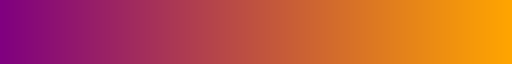

In [26]:
cmap